# Neural Style Transfer Exp:5
Context [here](https://dhruvs.space/posts/neural-style-transfer/).

Things explored:
- Reconstruction on album covers

See animations on [nbviewer](https://nbviewer.jupyter.org/github/dhth/neural-style-transfer-exps/blob/master/exp_5.ipynb).

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

Mounted at /content/gdrive


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3
!apt -qq install imagemagick

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
from math import ceil
from decimal import Decimal
from IPython.display import HTML

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
class NeuralStyleTransfer(object):
    
    def __init__(self,base_model,sz):
        self.base_model = base_model
        self.sz = sz
        self.model = to_gpu(base_model(True)).eval()
        set_trainable(self.model, False)
        self.trn_tfms,self.val_tfms = tfms_from_model(self.base_model, self.sz)
        
    def get_opt(self,img):
        opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
        opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
        opt_img_v = V(self.val_tfms(opt_img/2)[None], requires_grad=True)
        return opt_img_v, optim.LBFGS([opt_img_v])
    
    def step(self,loss_fn):
        self.optimizer.zero_grad()
        loss = loss_fn(self.opt_img_v)
        loss.backward()
        self.n_iter+=1
#         if self.print_losses:
#             if self.n_iter%self.show_iter==0: print(f'Iteration: {self.n_iter}, loss: {loss.data[0]}')
        return loss

    def scale_match(self, src, targ):
        h,w,_ = src.shape
        sh,sw,_ = targ.shape
        rat = max(h/sh,w/sw); rat
        res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
        return res[:h,:w]
    
    def gram(self,input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

    def gram_mse_loss(self,input, target):
        return F.mse_loss(self.gram(input), self.gram(target))
    
    def comb_loss(self,x):
        self.model(self.opt_img_v)
        content_outs = [V(o.features) for o in self.content_sfs]
        style_outs = [V(o.features) for o in self.style_sfs]
        
#         content_loss
        content_losses   = [F.mse_loss(o, s) 
                        for o,s in zip(content_outs, self.targ_vs)]
    
#         style_loss
        style_losses = [self.gram_mse_loss(o, s) 
                        for o,s in zip(style_outs, self.targ_styles)]

    
        if self.content_layers_weights is None:
            content_loss = sum(content_losses)
        else:
            content_loss = sum([a*b for a,b in 
                                zip(content_losses,self.content_layers_weights)])
            
        if self.style_layers_weights is None:
            style_loss = sum(style_losses)
        else:
            style_loss = sum([a*b for a,b in 
                              zip(style_losses,self.style_layers_weights)])
        if self.print_losses:
            if self.n_iter%self.show_iter==0:
                print(f'content: {self.alpha*content_loss.data[0]}, style: {self.beta*style_loss.data[0]}')
        
        if self.return_intermediates and self.n_iter<=self.gif_iter_till:
            if self.n_iter%self.gif_iter==0:
                self.intermediate_images.append(self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0])
        
        return self.alpha*content_loss + self.beta*style_loss

    def generate(self, content_image, style_img,
                 style_layers, content_layers,
                 alpha=1e6,
                 beta=1.,
                 content_layers_weights=None,
                 style_layers_weights=None,
                 max_iter=500,show_iter=300,
                 print_losses=False,
                 scale_style_img=True,
                 return_intermediates=False,
                 gif_iter=50,
                 gif_iter_till=500):
        
        self.max_iter = max_iter
        self.show_iter = show_iter
        self.gif_iter = gif_iter
        self.gif_iter_till = gif_iter_till
        
        self.alpha = alpha
        self.beta = beta
        self.content_layers_weights = content_layers_weights
        self.style_layers_weights = style_layers_weights
        self.print_losses = print_losses
        self.return_intermediates = return_intermediates
        self.intermediate_images = []

        self.content_sfs = [SaveFeatures(children(self.model)[idx]) for idx in content_layers]
        
        self.style_sfs = [SaveFeatures(children(self.model)[idx]) for idx in style_layers]
        
#         get target content
        img_tfm = self.val_tfms(content_image)
        self.opt_img_v, self.optimizer = self.get_opt(content_image)
        self.model(VV(img_tfm[None]))
        self.targ_vs = [V(o.features.clone()) for o in self.content_sfs]

#         get target style
        if scale_style_img:
            style_img = self.scale_match(content_image, style_img)
        self.style_tfm = self.val_tfms(style_img)
        self.model(VV(self.style_tfm[None]))
        self.targ_styles = [V(o.features.clone()) for o in self.style_sfs]
        
        self.n_iter=0

        while self.n_iter <= self.max_iter: self.optimizer.step(partial(self.step,self.comb_loss))
        for sf in self.content_sfs: sf.close()
        for sf in self.style_sfs: sf.close()
        if not self.return_intermediates:
            return self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0]
        else:
            return self.intermediate_images

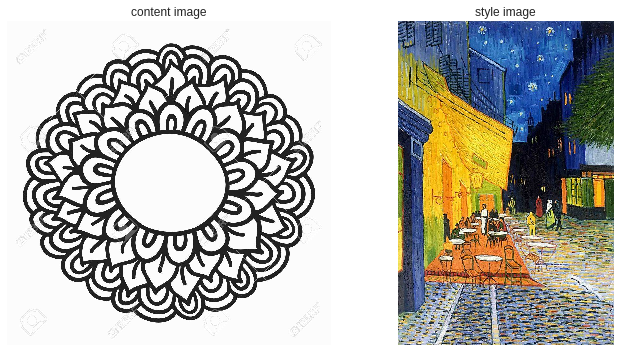

In [0]:
PATH = Path('data/imagenet')
PATH_IMAGES = PATH/'images'
PATH_STYLE = PATH/'style'

!mkdir -p {PATH_IMAGES}
!mkdir -p {PATH_STYLE}

!wget -qq https://previews.123rf.com/images/illucesco/illucesco1605/illucesco160500035/57523087-simple-doodle-flower-hand-drawn-vector-illustration.jpg -O {PATH_IMAGES}/farm.jpg
content_img = open_image(PATH_IMAGES/'farm.jpg')

!wget -qq https://media.overstockart.com/optimized/cache/data/product_images/VG1540-1000x1000.jpg -O {PATH_STYLE}/'cafe_terrace.jpg'
style_img = open_image(PATH_STYLE/'cafe_terrace.jpg')

images = [content_img,style_img]
titles = ['content image', 'style image']

fig,axes = plt.subplots(1,2,figsize=(10,5))
for i,ax in enumerate(axes.flat):
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(titles[i])
    ax.imshow(images[i]);
plt.tight_layout()
plt.show()

In [0]:
def show_images(images):
    num_cols = 2
    num_rows = ceil(len(images)/num_cols)
    img_size = 3
    fig,axes = plt.subplots(num_rows,num_cols,
                            figsize=(img_size*num_cols,img_size*num_rows))
    for i,ax in enumerate(axes.flat):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
#         ax.set_title(titles[i])
        ax.imshow(images[i]);
    plt.tight_layout()
    plt.show()

In [0]:
def show_img(images):
    num_cols = 3
    num_rows = len(images)//3
    fig,axes = plt.subplots(num_rows,3,figsize=(num_rows*,5))
    for i,ax in enumerate(axes.flat):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(titles[i])
        ax.imshow(images[i]);
    plt.tight_layout()
    plt.show()

In [0]:
t2 = NeuralStyleTransfer(vgg16,288)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:05<00:00, 101576035.98it/s]


In [0]:
t2.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

!wget -qq "https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg" -O data/imagenet/style/van_gogh_self_portrait.jpg
!wget -qq "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg" -O data/imagenet/style/kanagawa_wave.jpg
!wget -qq "https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg" -O data/imagenet/style/the_scream.jpg
!wget -qq "http://cdn.artobserved.com/2009/03/vincent-van-gogh-the-night-cafe-1888-via-artstor-collections.jpg" -O data/imagenet/style/the_night_cafe.jpg


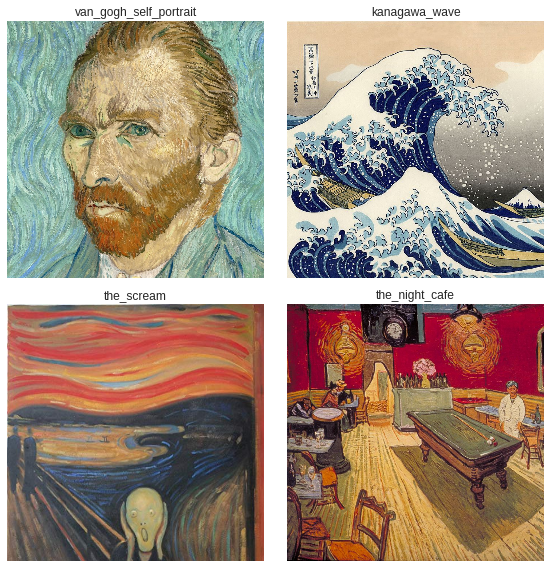

In [0]:
paintings = {
    "van_gogh_self_portrait":"https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg",
    "kanagawa_wave":"https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg",
    "the_scream":"https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg",
    "the_night_cafe":"http://cdn.artobserved.com/2009/03/vincent-van-gogh-the-night-cafe-1888-via-artstor-collections.jpg"
}

for painting in paintings:
    print(f'!wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg')
    !wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg
    
style_paintings = []
paintings_names = []

for painting in paintings:
    try:
        style_paintings.append(open_image(f'{PATH_STYLE}/{painting}.jpg'))
        paintings_names.append(painting)
    except Exception as e:
        print(str(e))
        
n_cols = 2
n_rows = ceil(len(style_paintings)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
        
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{paintings_names[i]}')
    ax.imshow(t2.scale_match(content_img, style_paintings[i]))
plt.tight_layout()
plt.show()

## Reconstruction GIFs for 4 paintings

In [0]:
def generate_anim(content_img, style_img,
                   gif_name,
                   content_layers=[16,22,26],
                   style_layers=[9,12,16,22,26],
                   alpha=1e5,
                   beta=3.,
                   style_layers_weights=None,
                   max_iter=800,show_iter=100,
                   print_losses=True,
                   scale_style_img=True,
                   return_intermediates=True,
                   gif_iter=10,
                   gif_iter_till=200):

    imgs = t2.generate(content_img, style_img,
                           content_layers=content_layers,
                           style_layers=style_layers,
                           alpha=alpha,
                           beta=beta,
                           style_layers_weights=style_layers_weights,
                           max_iter=max_iter,show_iter=show_iter,
                           print_losses=print_losses,
                           scale_style_img=scale_style_img,
                           return_intermediates=True,
                           gif_iter=gif_iter,
                           gif_iter_till=gif_iter_till)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    ims = []
    for i,img in enumerate(imgs):
        txt = plt.text(10,15,f'{i*gif_iter}',color='white', fontsize=16, weight='bold')
        im = ax.imshow(np.clip(img, 0, 1), interpolation='lanczos', animated=True)

        ims.append([im,txt])

    ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat=False)
    plt.close()
#     ani.save(gif_name, writer='imagemagick', fps=2)
    return ani

In [0]:
ani0 = generate_anim(content_img,style_img,'1',gif_iter_till=300)
HTML(ani0.to_html5_video())

content: 9105.69280385971, style: 42983.70703125
content: 3391.089290380478, style: 1200.7637329101562
content: 2952.9791325330734, style: 1027.3975524902344
content: 2829.410508275032, style: 948.478271484375
content: 2770.646847784519, style: 894.7044982910156
content: 2722.3730459809303, style: 867.6475524902344
content: 2693.41804087162, style: 851.7315673828125
content: 2671.908587217331, style: 840.0876159667969
content: 2656.7867025732994, style: 830.5251159667969


In [0]:
def image_from_url(url,name):
    !wget -qq {url} -O {PATH_IMAGES}/{name}.jpg
    return open_image(PATH_IMAGES/(name+'.jpg'))

In [0]:
mop = image_from_url('https://images.genius.com/8d290e7e3521598840f5800eb1c67e0c.1000x1000x1.jpg','mop')
rtl = image_from_url('https://images-na.ssl-images-amazon.com/images/I/81aSPOrkPjL._SL1425_.jpg','rtl')

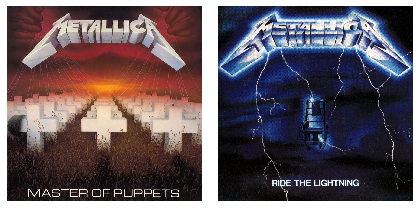

In [0]:
show_images([mop,rtl])

In [0]:
ani0 = generate_anim(mop,rtl,'1',gif_iter_till=300)
HTML(ani0.to_html5_video())

content: 5559.50403213501, style: 33156.1201171875
content: 2566.116489470005, style: 1772.8064575195312
content: 1804.6669661998749, style: 893.1183471679688
content: 1459.5835469663143, style: 590.7525787353516
content: 1257.9286471009254, style: 455.63360595703125
content: 1151.65114402771, style: 412.50132751464844
content: 1084.8878882825375, style: 393.58470153808594
content: 1041.0798713564873, style: 381.7979507446289
content: 1011.968869715929, style: 374.6470184326172


In [0]:
ani0 = generate_anim(rtl,mop,'1',gif_iter_till=300)
HTML(ani0.to_html5_video())

In [0]:
ani0.save('rtl.gif', writer='imagemagick', fps=2)

In [0]:
def reconstruct(content_img, style_img,
                   content_layers=[19,22],
                   style_layers=[9,12,16,22,],
                   alpha=1e5,
                   beta=1.,
                   scale_style_img=True,
                   max_iter=1000,show_iter=100,
                   print_losses=True):
    
    fig,ax = plt.subplots(1,1, figsize=(6,6))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    gen4 = t2.generate(content_img, style_img,
                       content_layers=content_layers,
                       style_layers=style_layers,
                       alpha=alpha,
                       beta=beta,
                       scale_style_img=scale_style_img,
                       max_iter=max_iter,show_iter=show_iter,
                       print_losses=print_losses)

    x = np.clip(gen4, 0, 1)
    ax.imshow(x,interpolation='lanczos')
    plt.show()
    return x

content: 3901.0442793369293, style: 29559.3779296875
content: 1187.407597899437, style: 655.0262145996094
content: 744.0021727234125, style: 413.99620056152344
content: 606.3554435968399, style: 343.97742462158203
content: 546.6129630804062, style: 312.731689453125
content: 515.7859064638615, style: 294.65602111816406
content: 498.5690116882324, style: 283.1319122314453
content: 486.7364652454853, style: 275.2444152832031
content: 479.26735132932663, style: 269.4562683105469
content: 473.72663393616676, style: 265.12300872802734
content: 469.56189908087254, style: 261.05735778808594


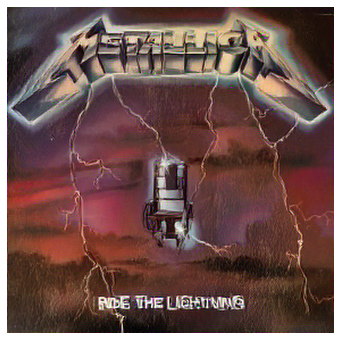

In [0]:
x = reconstruct(rtl,mop,beta=3.)

content: 3888.649493455887, style: 25803.1904296875
content: 1427.0662330091, style: 818.4549865722656
content: 994.1644035279751, style: 481.91917419433594
content: 864.7054433822632, style: 402.7954559326172
content: 814.6221749484539, style: 373.4828796386719
content: 790.8357307314873, style: 356.40987396240234
content: 775.7878862321377, style: 343.2326202392578
content: 764.0969939529896, style: 332.57350158691406
content: 755.6984201073647, style: 323.8784408569336
content: 749.0123156458139, style: 316.85765075683594
content: 743.4736005961895, style: 311.52527618408203


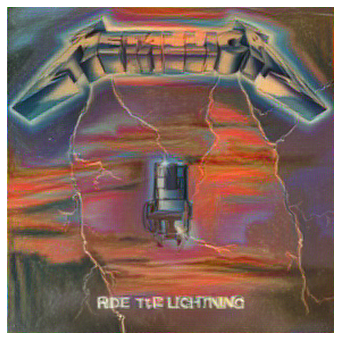

In [0]:
x = reconstruct(rtl,style_paintings[2],beta=3.)

In [0]:
ani0 = generate_anim(rtl,style_paintings[2],'1',gif_iter_till=250)
ani0.save('rtl2.gif', writer='imagemagick', fps=2)

content: 5424.784868955612, style: 25622.419921875
content: 1841.0854041576385, style: 924.5986633300781
content: 1336.8619605898857, style: 624.8098754882812
content: 1185.0121431052685, style: 549.7875823974609
content: 1125.6559751927853, style: 521.356201171875
content: 1096.9839058816433, style: 504.7500457763672
content: 1080.2543722093105, style: 493.1498565673828
content: 1068.4095323085785, style: 485.10328674316406
content: 1059.7779415547848, style: 478.5157470703125


In [0]:
HTML(ani0.to_html5_video())

In [0]:
ajfa = image_from_url('https://www.cede.de/covers/catalog/16376000/16376016_1_92.jpg','ajfa')
kea = image_from_url('https://images.genius.com/2c32cb43a7543dc36c8138481e44b94d.1000x1000x1.png','kea')

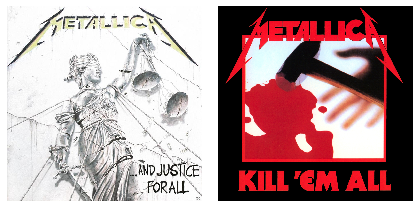

In [0]:
show_images([ajfa,kea])

content: 41846.65530920029, style: 103585.625
content: 17506.200820207596, style: 22190.6494140625
content: 15541.4380133152, style: 14381.14501953125
content: 14167.161658406258, style: 10518.96240234375
content: 13051.813468337059, style: 7869.652099609375
content: 12129.312381148338, style: 6145.3778076171875
content: 11491.572484374046, style: 5034.764404296875
content: 10996.147990226746, style: 4251.488952636719
content: 10539.751499891281, style: 3621.2173461914062
content: 10194.998234510422, style: 3183.4982299804688
content: 9945.823810994625, style: 2841.0040283203125


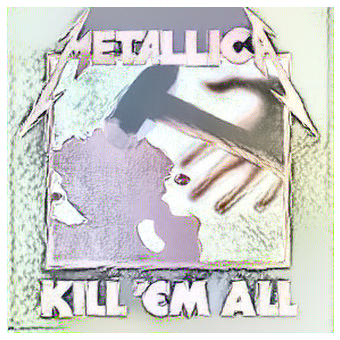

In [0]:
reconstruct(kea,ajfa,alpha=1e6,
                   beta=5.)

In [0]:
ani0 = generate_anim(kea,style_paintings[1],'1',gif_iter_till=250)
ani0.save('rtl2.gif', writer='imagemagick', fps=2)

content: 6520.345062017441, style: 73518.931640625
content: 3962.2031152248383, style: 1793.655029296875
content: 3313.157707452774, style: 1062.8881530761719
content: 2986.110746860504, style: 842.4645080566406
content: 2780.674211680889, style: 734.9358215332031
content: 2654.4280350208282, style: 676.1163024902344
content: 2567.5399228930473, style: 638.5028228759766
content: 2502.8016418218613, style: 614.6688537597656
content: 2453.3268064260483, style: 596.0009307861328


In [0]:
HTML(ani0.to_html5_video())

In [0]:
# get token from
# https://api.imgur.com/oauth2/authorize?client_id=CLIENT_ID&response_type=token&state=none

In [0]:
import base64

In [0]:
import pprint

In [0]:
import json

In [0]:
def upload_to_imgur(file_name,post_title,album_hash):
    url = 'https://api.imgur.com/3/image'
    fh = open(file_name, 'rb');
    payload = {'image': base64.b64encode(fh.read()),
              'album':album_hash,
              'type':'base64',
              'title':post_title,
              'looping':False
              }
    files = {}
    headers = {
      'Authorization': f'Bearer {ACCESS_TOKEN}'
    }
    response = requests.request('POST', url, headers = headers, data = payload, files = files, allow_redirects=False)
    pprint.pprint(response.json())

In [0]:
upload_to_imgur('rtl2.gif',
                'Style-Transfer: Kill em all in the style of The Kanagawa Wave')

{'data': {'account_id': 12935473,
          'account_url': None,
          'ad_type': 0,
          'ad_url': '',
          'animated': True,
          'bandwidth': 0,
          'datetime': 1547812066,
          'deletehash': 'KpPWWtrGbrwSxHi',
          'description': None,
          'favorite': False,
          'gifv': 'https://i.imgur.com/AX8E6xg.gifv',
          'has_sound': False,
          'height': 360,
          'hls': 'https://i.imgur.com/AX8E6xg.m3u8',
          'id': 'AX8E6xg',
          'in_gallery': False,
          'in_most_viral': False,
          'is_ad': False,
          'link': 'https://i.imgur.com/AX8E6xg.gif',
          'looping': True,
          'mp4': 'https://i.imgur.com/AX8E6xg.mp4',
          'mp4_size': 0,
          'name': '',
          'nsfw': None,
          'section': None,
          'size': 3498754,
          'tags': [],
          'title': 'Style-Transfer: Kill em all in the style of The Kanagawa '
                   'Wave',
          'type': 'image/gif',


In [0]:
arkham = image_from_url('https://i.imgur.com/BFgQRSi.jpg','arkham')

In [0]:
starry_night = image_from_url('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg','starry_night')

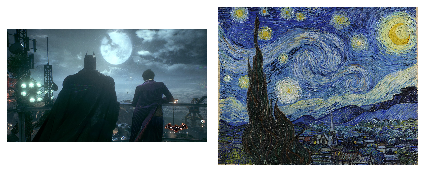

In [0]:
show_images([arkham,starry_night])

In [0]:
def get_image_info(image_hash):
    
    url = f'https://api.imgur.com/3/image/{image_hash}'

    headers = {
      'Authorization': f'Bearer {ACCESS_TOKEN}'
    }
    response = requests.request('GET', url, headers = headers,allow_redirects=False)
    pprint.pprint(response.json())

In [0]:
t2 = NeuralStyleTransfer(vgg16,800)

content: 2956.387773156166, style: 29083.5556640625
content: 969.3259373307228, style: 212.57949829101562
content: 663.9345549046993, style: 125.38644790649414
content: 577.3209501057863, style: 118.51219940185547
content: 541.3802806288004, style: 117.34835815429688
content: 520.9559109061956, style: 116.90007019042969
content: 507.45378248393536, style: 116.72735595703125
content: 497.9050252586603, style: 116.64492416381836
content: 490.8560309559107, style: 116.5279312133789
content: 485.2436017245054, style: 116.50075149536133
content: 480.7744175195694, style: 116.45941543579102


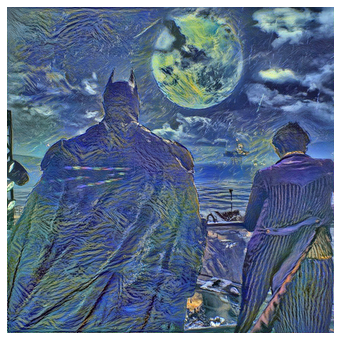

In [330]:
x = reconstruct(arkham,starry_night,alpha=1e5,
                   beta=3.)

In [0]:
import matplotlib.gridspec as gridspec

In [0]:
def plot_result(content_img,style_img,reconstructed,
                save_name=None,
                cell_size=3):
    fig = plt.figure(figsize=(cell_size*3,cell_size*2))
    gs = gridspec.GridSpec(2, 3)
    content_ax = plt.subplot(gs[0, 0])
    reconstructed_ax = plt.subplot(gs[0:, 1:])
    style_ax = plt.subplot(gs[1, 0])

    for ax in [content_ax,reconstructed_ax,style_ax]:
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    content_img_tfmd = t2.val_tfms.denorm(np.rollaxis(t2.val_tfms(content_img)[None],1,4))[0]    
    style_img_scaled = t2.scale_match(content_img_tfmd, style_img)
    style_img_tfmd = t2.val_tfms.denorm(np.rollaxis(t2.val_tfms(style_img_scaled)[None],1,4))[0]

    content_ax.imshow(content_img_tfmd)
    content_ax.set_title('content')
    reconstructed_ax.imshow(reconstructed)
    reconstructed_ax.set_title('reconstructed')
    style_ax.imshow(style_img_tfmd)
    style_ax.set_title('style')
    reconstructed_ax.text(.95,-0.02, "by dhruv", size=12, ha="center", 
         transform=reconstructed_ax.transAxes)
    plt.tight_layout()
    if not save_name is None:
        plt.savefig(save_name)
    plt.show()

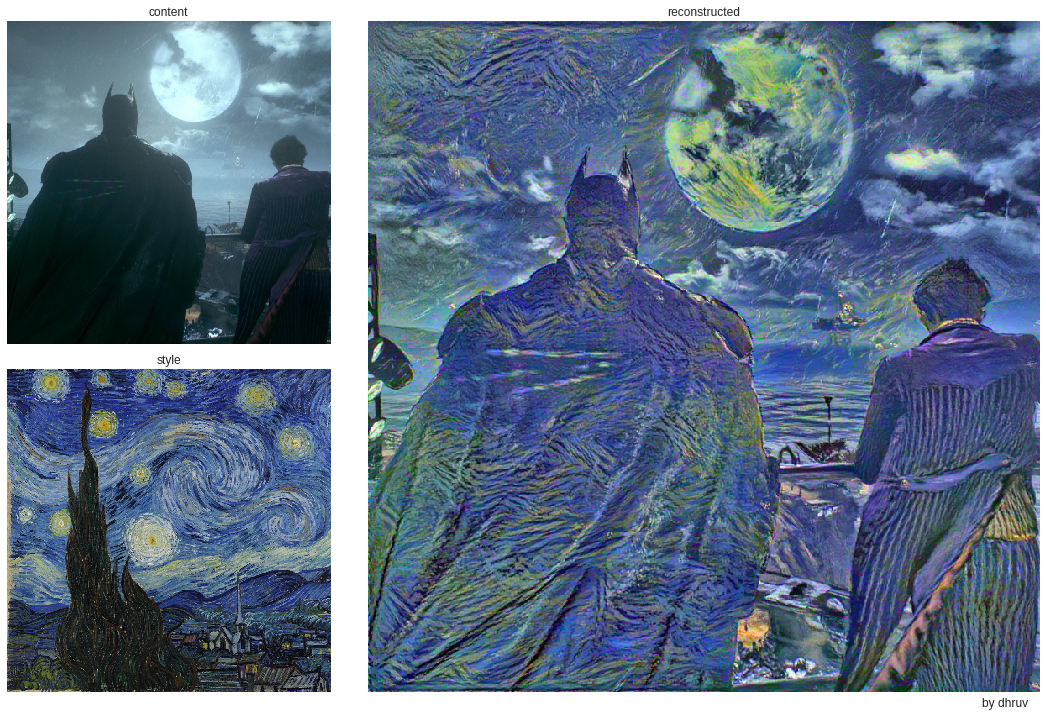

In [332]:
plot_result(arkham,starry_night,x,cell_size=5,save_name='arkham2.png')

In [333]:
upload_to_imgur('arkham2.png','Style Transfer: Arkham Knight and Starry Night','SCyZcVi')

{'data': {'account_id': 12935473,
          'account_url': None,
          'ad_type': 0,
          'ad_url': '',
          'animated': False,
          'bandwidth': 0,
          'datetime': 1547818707,
          'deletehash': 'KAavOl2oQeapErt',
          'description': None,
          'favorite': False,
          'has_sound': False,
          'height': 720,
          'id': 'QS4HXp8',
          'in_gallery': False,
          'in_most_viral': False,
          'is_ad': False,
          'link': 'https://i.imgur.com/QS4HXp8.png',
          'name': '',
          'nsfw': None,
          'section': None,
          'size': 1756420,
          'tags': [],
          'title': 'Style Transfer: Arkham Knight and Starry Night',
          'type': 'image/png',
          'views': 0,
          'vote': None,
          'width': 1080},
 'status': 200,
 'success': True}
